In [1]:
# !pip install fastaudio
# !pip install fastai==2.5.2
# !pip install matplotlib==3.2.2
# !pip install scikit-learn==1.0.2

In [2]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *
from fastaudio.ci import skip_if_ci

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import*
from imblearn.metrics import specificity_score
from keras.utils.np_utils import to_categorical   

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:47: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  '"torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. '


# Data preprocessing 

## Load data

In [3]:
# select data path
path = '../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/'

In [4]:
# load the given csv file
org_df = pd.read_csv(path+"patient_diagnosis.csv", names=['pid', 'label'])
org_df.head()

pid    label
0  101     URTI
1  102  Healthy
2  103   Asthma
3  104     COPD
4  105     URTI

In [5]:
# load all audio file paths in a list
all_files = get_files(path, extensions='.wav', recurse=True)
all_files[:3]

(#3) [Path('../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/162_1b2_Ar_mc_AKGC417L.wav'),Path('../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/193_1b2_Pl_mc_AKGC417L.wav'),Path('../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/138_2p2_Ll_mc_AKGC417L.wav')]

## Create dataframe for dataloader

In [6]:
# save all audios filename and it's corresponding labels in lists
file_names = []
labels = []
for i in all_files:
    name = str(i).split('/')[-1]
    id = name.split('_')[0]
    label = org_df[org_df['pid']==int(id)]['label'].values[0]
    if (label != 'Asthma' and label !='LRTI'):
        labels.append(label)
        file_names.append(name)
    
print("total files:", len(file_names))
print("total labels:", len(labels))

print(file_names[:3])
print(labels[:3])

Counter(labels)

total files: 917
total labels: 917
['162_1b2_Ar_mc_AKGC417L.wav', '193_1b2_Pl_mc_AKGC417L.wav', '138_2p2_Ll_mc_AKGC417L.wav']
['COPD', 'COPD', 'COPD']


Counter({'COPD': 793,
         'Bronchiectasis': 16,
         'URTI': 23,
         'Pneumonia': 37,
         'Bronchiolitis': 13,
         'Healthy': 35})

In [7]:
# create a dataframe using the file_names and labels list
df = pd.DataFrame({'filename' : file_names, 'category': labels})
six_df = df.copy()
six_df

filename        category
0    162_1b2_Ar_mc_AKGC417L.wav            COPD
1    193_1b2_Pl_mc_AKGC417L.wav            COPD
2    138_2p2_Ll_mc_AKGC417L.wav            COPD
3    207_2b2_Ar_mc_AKGC417L.wav            COPD
4    176_2b3_Pr_mc_AKGC417L.wav            COPD
..                          ...             ...
912  162_2b4_Al_mc_AKGC417L.wav            COPD
913  186_2b3_Ar_mc_AKGC417L.wav            COPD
914  111_1b3_Tc_sc_Meditron.wav  Bronchiectasis
915  151_2p3_Al_mc_AKGC417L.wav            COPD
916  170_1b4_Pl_mc_AKGC417L.wav            COPD

[917 rows x 2 columns]

COPD              793
Pneumonia          37
Healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
Name: category, dtype: int64

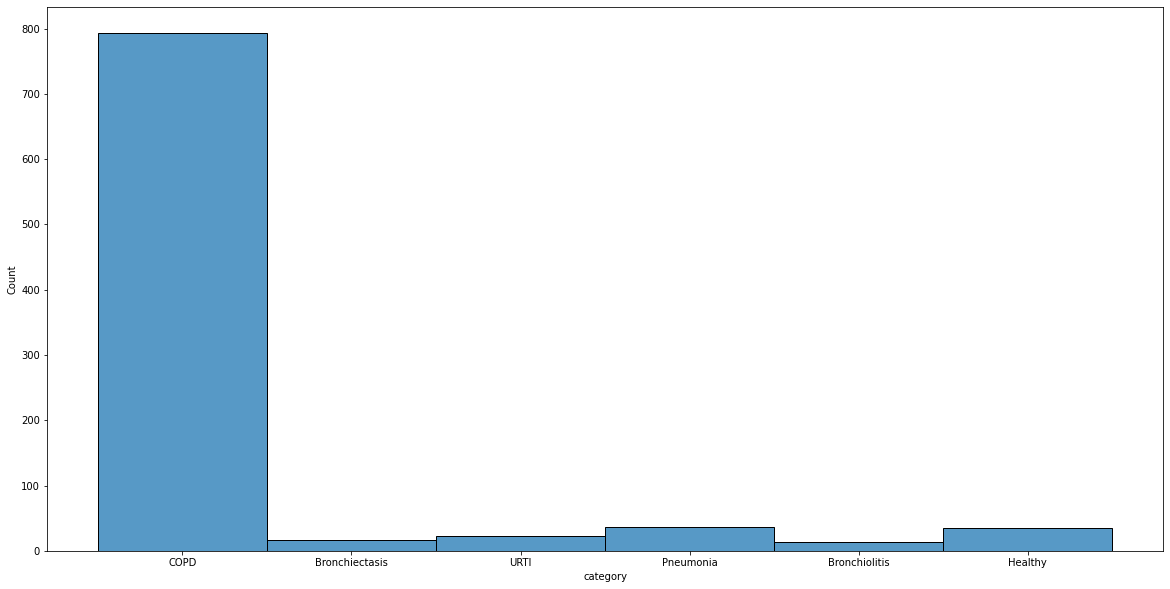

In [8]:
import seaborn as sns

plt.figure(figsize=(20,10))
sns.histplot(six_df['category'])

six_df['category'].value_counts()

In [9]:
six_df.to_csv('six_df.csv', index=False) 

## Mel-Spectrogram

In [10]:
# resize audio to a uniform length and create mel-spectrogram from audio

cfg = AudioConfig.BasicMelSpectrogram(sample_rate=22050, n_fft=1024, hop_length=512, f_min=0.0, f_max=4000,
                                      n_mels=64, normalized=False, norm=None, mel=True, to_db=True)

a2s = AudioToSpec.from_cfg(cfg)
crop21s = ResizeSignal(21000)

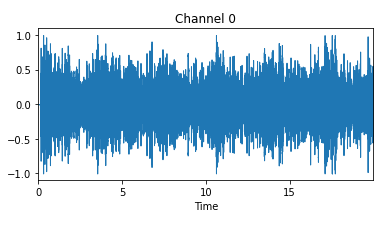

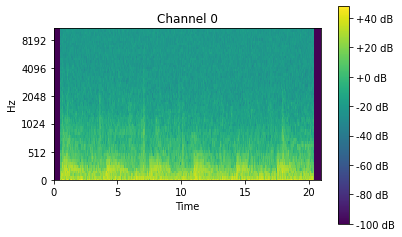

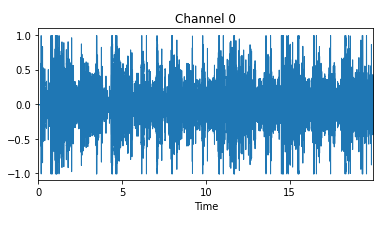

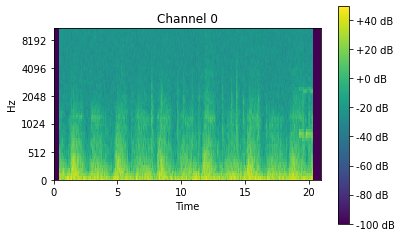

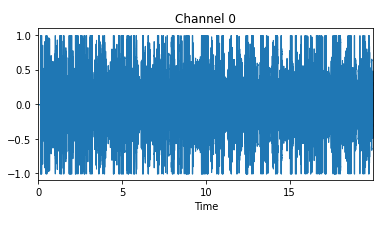

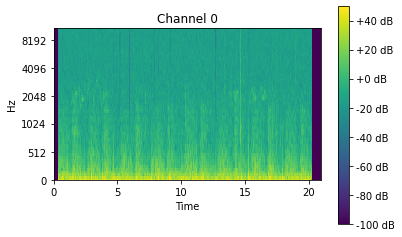

In [11]:
# check transformations
pipe = Pipeline([AudioTensor.create, crop21s, a2s])

for fn in all_files[66:69]:
      audio = AudioTensor.create(fn)
      audio.show()
      pipe(fn).show()

## Dataloader

In [12]:
six_df, six_df_test = train_test_split(six_df, test_size=0.20, random_state=42, 
                                       stratify=six_df.category.values)

print(six_df.category.value_counts())
print(six_df_test.category.value_counts())

COPD              634
Pneumonia          30
Healthy            28
URTI               18
Bronchiectasis     13
Bronchiolitis      10
Name: category, dtype: int64
COPD              159
Healthy             7
Pneumonia           7
URTI                5
Bronchiolitis       3
Bronchiectasis      3
Name: category, dtype: int64


Setting-up type transforms pipelines
306  208_1b1_Ll_sc_Meditron.wav    Healthy
87   186_3b3_Pr_mc_AKGC417L.wav       COPD
725  162_2b3_Lr_mc_AKGC417L.wav       COPD
478  138_2p2_Lr_mc_AKGC417L.wav       COPD
105  182_1b1_Tc_sc_Meditron.wav    Healthy
..                          ...        ...
555  211_1p5_Ar_mc_AKGC417L.wav       COPD
120  205_3b4_Ar_mc_AKGC417L.wav       COPD
201  141_1b2_Pr_mc_LittC2SE.wav       COPD
687  166_1p1_Ar_sc_Meditron.wav       COPD
304  135_2b2_Tc_mc_LittC2SE.wav  Pneumonia

[733 rows x 2 columns]
Found 733 items
2 datasets of sizes 586,147
Setting up Pipeline: ColReader -- {'cols': 'filename', 'pref': '../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/', 'suff': '', 'label_delim': None} -> partial
Setting up Pipeline: ColReader -- {'cols': 'category', 'pref': '', 'suff': '', 'label_delim': None} -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: ColR

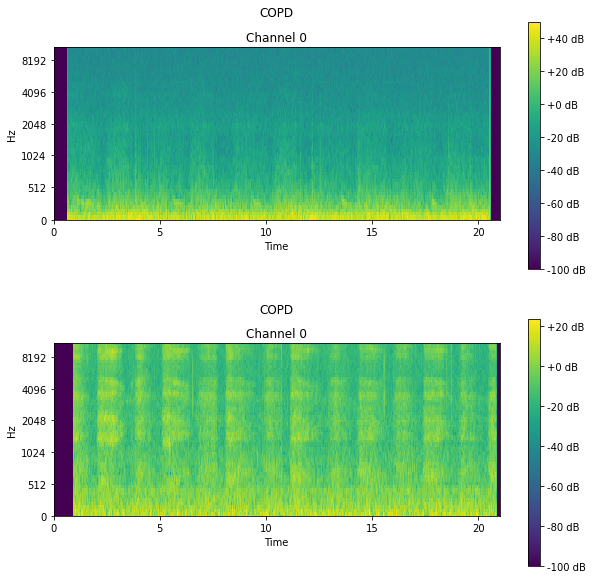

In [13]:
item_tfms = [crop21s, a2s]

auds = DataBlock(blocks = (AudioBlock, CategoryBlock),  
                 get_x = ColReader("filename", pref= path+"audio_and_txt_files/"),
                 splitter = TrainTestSplitter(test_size=0.2, random_state=42, 
                                              stratify=six_df.category.values),
                 item_tfms = item_tfms,
                 get_y = ColReader("category"))


auds.summary(six_df, show_batch=True, figsize=(10, 10))

## Check data distribution

In [14]:
dls = auds.dataloaders(six_df, bs=64)

for i in range(10):
    x,y = dls.one_batch()
    print(np.unique(y.cpu(), return_counts=True))

(array([0, 1, 2, 3, 4, 5]), array([ 1,  1, 53,  1,  4,  4]))
(array([0, 2, 3, 4, 5]), array([ 1, 54,  6,  1,  2]))
(array([0, 2, 3, 4, 5]), array([ 1, 57,  2,  1,  3]))
(array([2, 4, 5]), array([61,  1,  2]))
(array([0, 1, 2, 3, 4, 5]), array([ 1,  1, 57,  1,  2,  2]))
(array([0, 2, 3]), array([ 2, 61,  1]))
(array([1, 2, 3, 4, 5]), array([ 1, 58,  3,  1,  1]))
(array([0, 1, 2, 3, 4, 5]), array([ 1,  1, 53,  2,  3,  4]))
(array([0, 2, 3, 4, 5]), array([ 1, 53,  4,  4,  2]))
(array([0, 2, 3, 4, 5]), array([ 1, 56,  1,  4,  2]))


In [15]:
test_dl = dls.test_dl(six_df_test, with_labels=True)

In [16]:
print(dls.valid.items.category.value_counts())
print(dls.valid.items.category.value_counts())
print(test_dl.items.category.value_counts())

COPD              127
Pneumonia           6
Healthy             6
URTI                4
Bronchiectasis      2
Bronchiolitis       2
Name: category, dtype: int64
COPD              127
Pneumonia           6
Healthy             6
URTI                4
Bronchiectasis      2
Bronchiolitis       2
Name: category, dtype: int64
COPD              159
Healthy             7
Pneumonia           7
URTI                5
Bronchiolitis       3
Bronchiectasis      3
Name: category, dtype: int64


# Models: Fine-tuning

### ResNet-18

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.18367347121238708.


Better model found at epoch 0 with accuracy value: 0.36734694242477417.
Better model found at epoch 1 with accuracy value: 0.4217686951160431.
Better model found at epoch 2 with accuracy value: 0.5374149680137634.
Better model found at epoch 3 with accuracy value: 0.646258533000946.
Better model found at epoch 4 with accuracy value: 0.680272102355957.
Better model found at epoch 5 with accuracy value: 0.7687074542045593.
Better model found at epoch 6 with accuracy value: 0.8027210831642151.
Better model found at epoch 7 with accuracy value: 0.8299319744110107.
Better model found at epoch 8 with accuracy value: 0.8911564350128174.
Better model found at epoch 10 with accuracy value: 0.918367326259613.
Better model found at epoch 13 with accuracy value: 0.9387755393981934.
Better model found at epoch 17 with accuracy value: 0.9523809552192688.
No improvement since epoch 17: early stopping


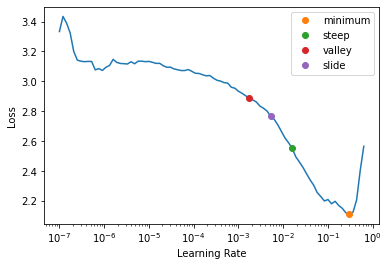

In [17]:
learn = cnn_learner(dls, resnet18, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fine_tune(50, lrs.valley)

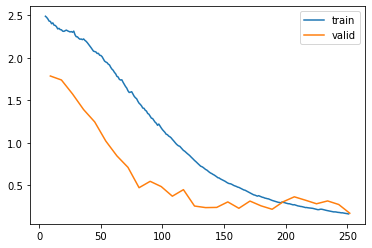

In [18]:
learn.recorder.plot_loss()

0.9021739130434783 0.6815872426335973 0.44716580146146717 0.420125786163522 0.9430486991036725 0.5438121047877146
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.00      0.00      0.00         3
           2       0.96      0.99      0.97       159
           3       0.56      0.71      0.63         7
           4       0.50      0.29      0.36         7
           5       0.25      0.20      0.22         5

    accuracy                           0.90       184
   macro avg       0.54      0.42      0.45       184
weighted avg       0.89      0.90      0.89       184



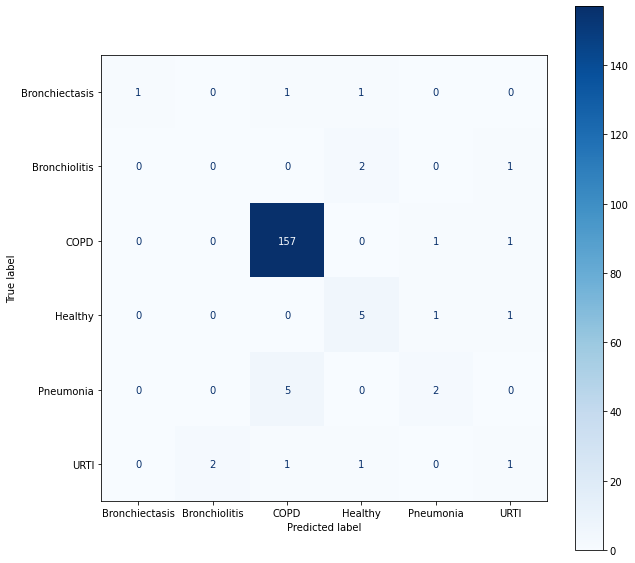

In [27]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=6)
pred_classesX = to_categorical(pred_classes, num_classes=6)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### ResNet-34

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.3333333432674408.


Better model found at epoch 0 with accuracy value: 0.44897958636283875.
Better model found at epoch 1 with accuracy value: 0.5374149680137634.
Better model found at epoch 2 with accuracy value: 0.7142857313156128.
Better model found at epoch 3 with accuracy value: 0.761904776096344.
Better model found at epoch 4 with accuracy value: 0.8435373902320862.
Better model found at epoch 5 with accuracy value: 0.8639456033706665.
Better model found at epoch 6 with accuracy value: 0.918367326259613.
Better model found at epoch 7 with accuracy value: 0.9387755393981934.
Better model found at epoch 8 with accuracy value: 0.9455782175064087.
Better model found at epoch 11 with accuracy value: 0.9523809552192688.
No improvement since epoch 11: early stopping


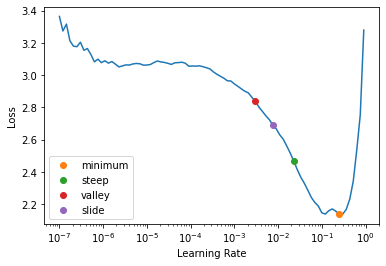

In [28]:
learn = cnn_learner(dls, resnet34, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fine_tune(50, lrs.valley)

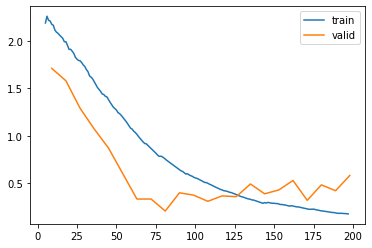

In [29]:
learn.recorder.plot_loss()

0.875 0.756896377552272 0.4762029873984333 0.5466606768493562 0.9671320782551879 0.47755439924314097
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.25      0.33      0.29         3
           1       0.20      0.67      0.31         3
           2       0.99      0.94      0.96       159
           3       0.43      0.43      0.43         7
           4       0.50      0.71      0.59         7
           5       0.50      0.20      0.29         5

    accuracy                           0.88       184
   macro avg       0.48      0.55      0.48       184
weighted avg       0.91      0.88      0.89       184



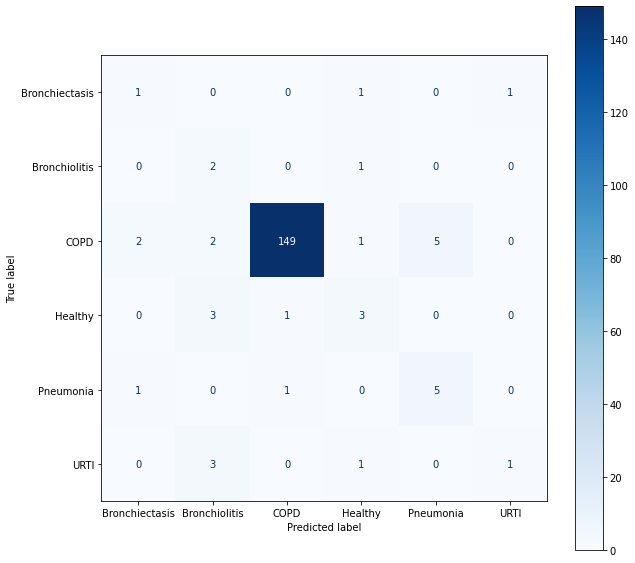

In [30]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=6)
pred_classesX = to_categorical(pred_classes, num_classes=6)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### ResNet-50

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.20408163964748383.


Better model found at epoch 0 with accuracy value: 0.18367347121238708.
Better model found at epoch 1 with accuracy value: 0.44897958636283875.
Better model found at epoch 2 with accuracy value: 0.6394557952880859.
Better model found at epoch 3 with accuracy value: 0.7278911471366882.
Better model found at epoch 4 with accuracy value: 0.8367347121238708.
Better model found at epoch 5 with accuracy value: 0.8435373902320862.
Better model found at epoch 6 with accuracy value: 0.9115646481513977.
Better model found at epoch 9 with accuracy value: 0.9387755393981934.
Better model found at epoch 12 with accuracy value: 0.9455782175064087.
No improvement since epoch 12: early stopping


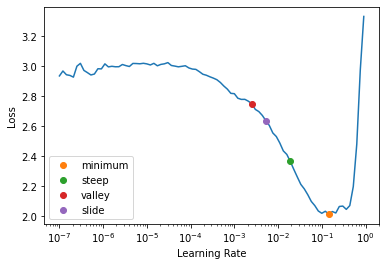

In [31]:
learn = cnn_learner(dls, resnet50, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fine_tune(50, lrs.valley)

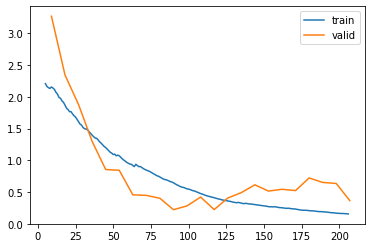

In [32]:
learn.recorder.plot_loss()

0.8804347826086957 0.7597441473501281 0.47097493150124725 0.5572327044025157 0.9622555902977404 0.4411764705882353
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.50      1.00      0.67         3
           2       0.98      0.94      0.96       159
           3       0.50      0.29      0.36         7
           4       0.42      0.71      0.53         7
           5       0.25      0.40      0.31         5

    accuracy                           0.88       184
   macro avg       0.44      0.56      0.47       184
weighted avg       0.90      0.88      0.88       184



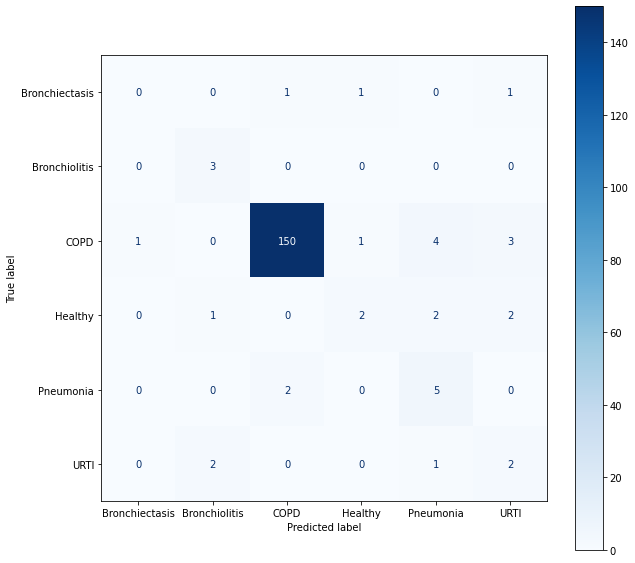

In [33]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=6)
pred_classesX = to_categorical(pred_classes, num_classes=6)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### ResNet-101

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.054421767592430115.


Better model found at epoch 0 with accuracy value: 0.10884353518486023.
Better model found at epoch 1 with accuracy value: 0.29931971430778503.
Better model found at epoch 2 with accuracy value: 0.49659863114356995.
Better model found at epoch 3 with accuracy value: 0.5442177057266235.
Better model found at epoch 4 with accuracy value: 0.5918367505073547.
Better model found at epoch 5 with accuracy value: 0.6870748400688171.
Better model found at epoch 6 with accuracy value: 0.7278911471366882.
Better model found at epoch 8 with accuracy value: 0.7414966225624084.
Better model found at epoch 9 with accuracy value: 0.8163265585899353.
Better model found at epoch 10 with accuracy value: 0.8571428656578064.
Better model found at epoch 11 with accuracy value: 0.8979591727256775.
Better model found at epoch 12 with accuracy value: 0.9115646481513977.
Better model found at epoch 13 with accuracy value: 0.9251700639724731.
Better model found at epoch 15 with accuracy value: 0.9319728016853333

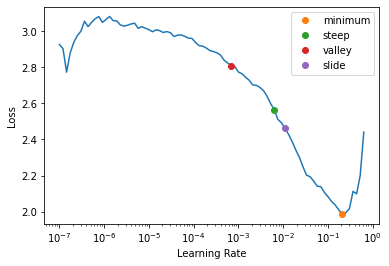

In [34]:
learn = cnn_learner(dls, resnet101, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fine_tune(50, lrs.valley)

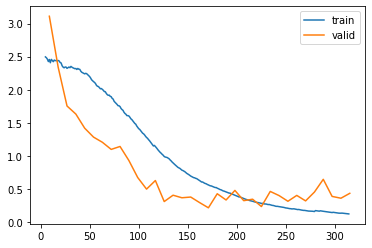

In [35]:
learn.recorder.plot_loss()

0.907608695652174 0.7950886941364517 0.5691986915754935 0.6175202156334232 0.97265717263948 0.5645161290322581
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.40      0.67      0.50         3
           2       0.99      0.96      0.97       159
           3       0.50      0.29      0.36         7
           4       0.50      0.86      0.63         7
           5       0.50      0.60      0.55         5

    accuracy                           0.91       184
   macro avg       0.56      0.62      0.57       184
weighted avg       0.92      0.91      0.91       184



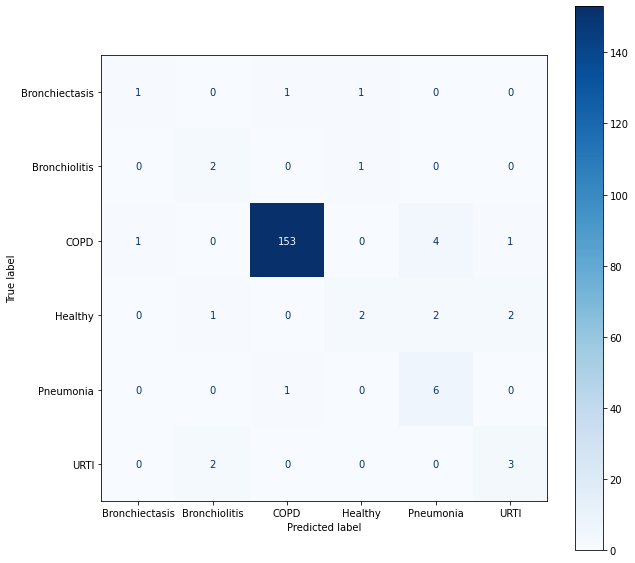

In [36]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=6)
pred_classesX = to_categorical(pred_classes, num_classes=6)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### vgg16_bn

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.10884353518486023.


Better model found at epoch 0 with accuracy value: 0.4353741407394409.
Better model found at epoch 1 with accuracy value: 0.5986394286155701.
Better model found at epoch 2 with accuracy value: 0.680272102355957.
Better model found at epoch 3 with accuracy value: 0.761904776096344.
Better model found at epoch 4 with accuracy value: 0.7687074542045593.
Better model found at epoch 5 with accuracy value: 0.8503401279449463.
Better model found at epoch 6 with accuracy value: 0.8911564350128174.
Better model found at epoch 7 with accuracy value: 0.9047619104385376.
Better model found at epoch 8 with accuracy value: 0.918367326259613.
Better model found at epoch 10 with accuracy value: 0.9251700639724731.
Better model found at epoch 11 with accuracy value: 0.9455782175064087.
No improvement since epoch 11: early stopping


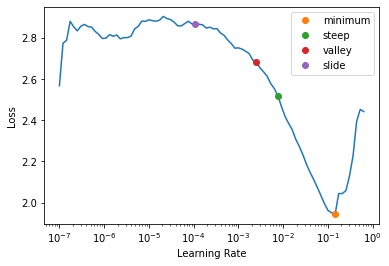

In [37]:
learn = cnn_learner(dls, vgg16_bn, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fine_tune(50, lrs.valley)

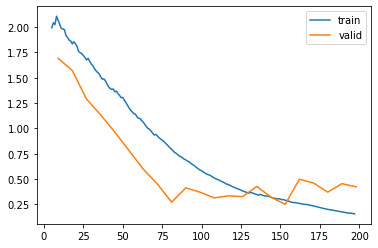

In [38]:
learn.recorder.plot_loss()

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: 

0.8967391304347826 0.8037487444674888 0.4914247111699341 0.6365678346810423 0.9709296542539355 0.4724706744868035
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.38      1.00      0.55         3
           1       0.27      1.00      0.43         3
           2       0.99      0.96      0.97       159
           3       0.40      0.29      0.33         7
           4       0.80      0.57      0.67         7
           5       0.00      0.00      0.00         5

    accuracy                           0.90       184
   macro avg       0.47      0.64      0.49       184
weighted avg       0.91      0.90      0.90       184



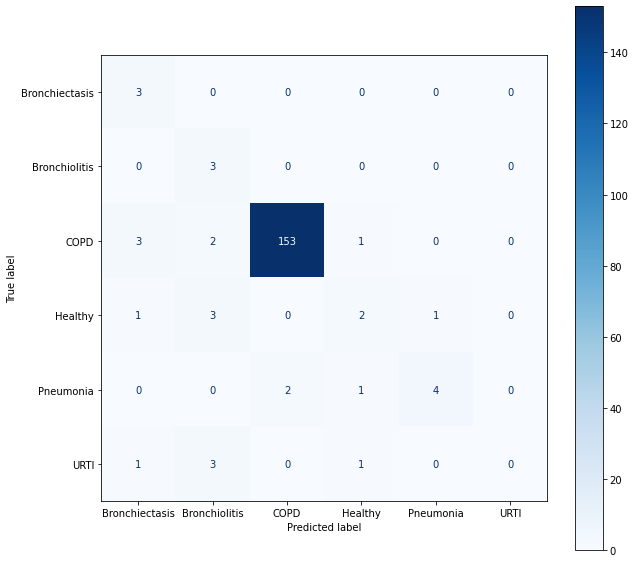

In [39]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=6)
pred_classesX = to_categorical(pred_classes, num_classes=6)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### vgg19_bn

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.3469387888908386.


Better model found at epoch 0 with accuracy value: 0.2925170063972473.
Better model found at epoch 1 with accuracy value: 0.3945578336715698.
Better model found at epoch 2 with accuracy value: 0.5646258592605591.
Better model found at epoch 3 with accuracy value: 0.7278911471366882.
Better model found at epoch 4 with accuracy value: 0.7687074542045593.
Better model found at epoch 5 with accuracy value: 0.8367347121238708.
Better model found at epoch 6 with accuracy value: 0.9047619104385376.
Better model found at epoch 7 with accuracy value: 0.9115646481513977.
Better model found at epoch 8 with accuracy value: 0.918367326259613.
Better model found at epoch 9 with accuracy value: 0.9251700639724731.
Better model found at epoch 10 with accuracy value: 0.9319728016853333.
Better model found at epoch 16 with accuracy value: 0.9387755393981934.
Better model found at epoch 19 with accuracy value: 0.9659863710403442.
No improvement since epoch 19: early stopping


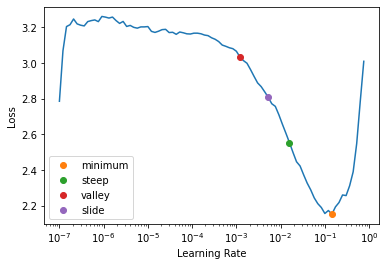

In [40]:
learn = cnn_learner(dls, vgg19_bn, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fine_tune(50, lrs.valley)

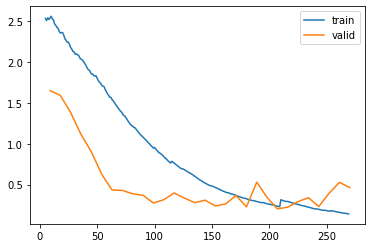

In [41]:
learn.recorder.plot_loss()

0.9239130434782609 0.8297976374695941 0.6018416768416769 0.6783468104222821 0.9812484645169061 0.6044871794871794
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.30      1.00      0.46         3
           2       0.99      0.97      0.98       159
           3       0.67      0.57      0.62         7
           4       0.67      0.86      0.75         7
           5       0.00      0.00      0.00         5

    accuracy                           0.92       184
   macro avg       0.60      0.68      0.60       184
weighted avg       0.93      0.92      0.92       184



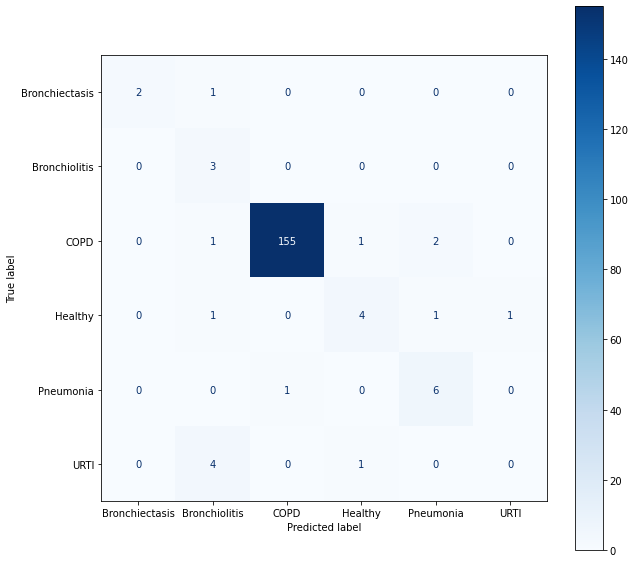

In [42]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=6)
pred_classesX = to_categorical(pred_classes, num_classes=6)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### alexnet

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.41496598720550537.


Better model found at epoch 0 with accuracy value: 0.5170068144798279.
Better model found at epoch 1 with accuracy value: 0.5510203838348389.
Better model found at epoch 2 with accuracy value: 0.5918367505073547.
Better model found at epoch 3 with accuracy value: 0.6870748400688171.
Better model found at epoch 4 with accuracy value: 0.7006802558898926.
Better model found at epoch 5 with accuracy value: 0.7142857313156128.
Better model found at epoch 6 with accuracy value: 0.795918345451355.
Better model found at epoch 7 with accuracy value: 0.8435373902320862.
Better model found at epoch 9 with accuracy value: 0.8571428656578064.
Better model found at epoch 10 with accuracy value: 0.8911564350128174.
Better model found at epoch 11 with accuracy value: 0.8979591727256775.
Better model found at epoch 19 with accuracy value: 0.9115646481513977.
Better model found at epoch 26 with accuracy value: 0.918367326259613.
Better model found at epoch 29 with accuracy value: 0.9251700639724731.
No 

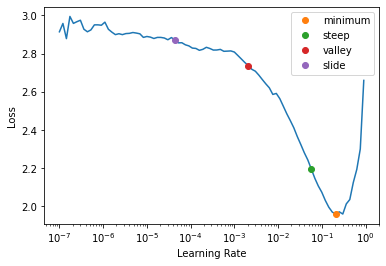

In [43]:
learn = cnn_learner(dls, alexnet, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fine_tune(50, lrs.valley)

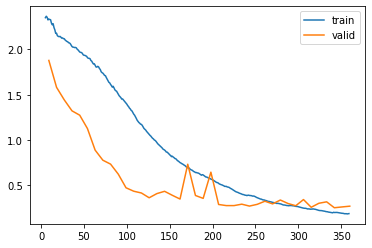

In [44]:
learn.recorder.plot_loss()

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: 

0.8858695652173914 0.6498724287822978 0.3388034188034188 0.3709194369571727 0.9288254206074228 0.33858290304073435
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.29      0.67      0.40         3
           2       0.95      0.99      0.97       159
           3       0.40      0.29      0.33         7
           4       0.40      0.29      0.33         7
           5       0.00      0.00      0.00         5

    accuracy                           0.89       184
   macro avg       0.34      0.37      0.34       184
weighted avg       0.85      0.89      0.87       184



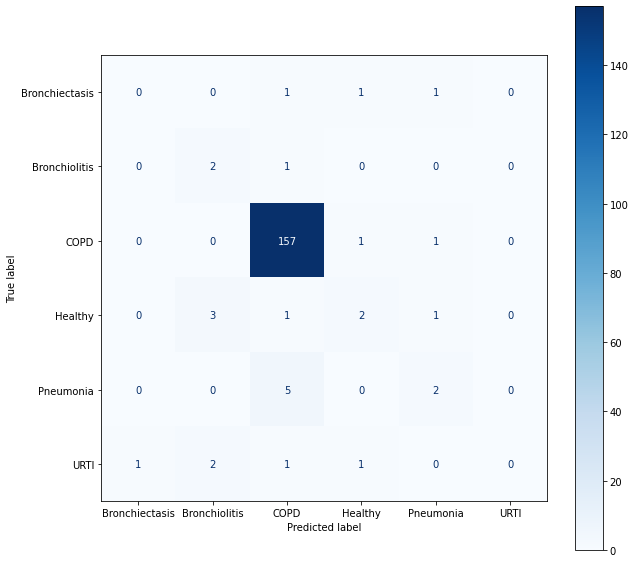

In [45]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=6)
pred_classesX = to_categorical(pred_classes, num_classes=6)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### squeezenet1_0

Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.5646258592605591.


Better model found at epoch 0 with accuracy value: 0.5986394286155701.
Better model found at epoch 1 with accuracy value: 0.6598639488220215.
Better model found at epoch 3 with accuracy value: 0.6938775777816772.
Better model found at epoch 4 with accuracy value: 0.8367347121238708.
Better model found at epoch 8 with accuracy value: 0.8435373902320862.
Better model found at epoch 9 with accuracy value: 0.8707482814788818.
Better model found at epoch 11 with accuracy value: 0.8775510191917419.
Better model found at epoch 12 with accuracy value: 0.8911564350128174.
Better model found at epoch 14 with accuracy value: 0.9047619104385376.
Better model found at epoch 17 with accuracy value: 0.918367326259613.
No improvement since epoch 17: early stopping


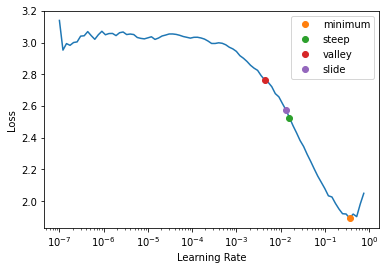

In [46]:
learn = cnn_learner(dls, squeezenet1_0, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fine_tune(50, lrs.valley)

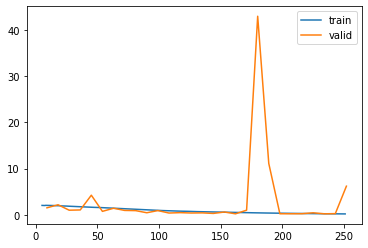

In [47]:
learn.recorder.plot_loss()

0.8913043478260869 0.7230143244533463 0.4977052959811581 0.5048218029350104 0.9412068459716822 0.5406881313131313
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.50      0.67      0.57         3
           2       0.96      0.96      0.96       159
           3       0.67      0.29      0.40         7
           4       0.45      0.71      0.56         7
           5       0.67      0.40      0.50         5

    accuracy                           0.89       184
   macro avg       0.54      0.50      0.50       184
weighted avg       0.90      0.89      0.89       184



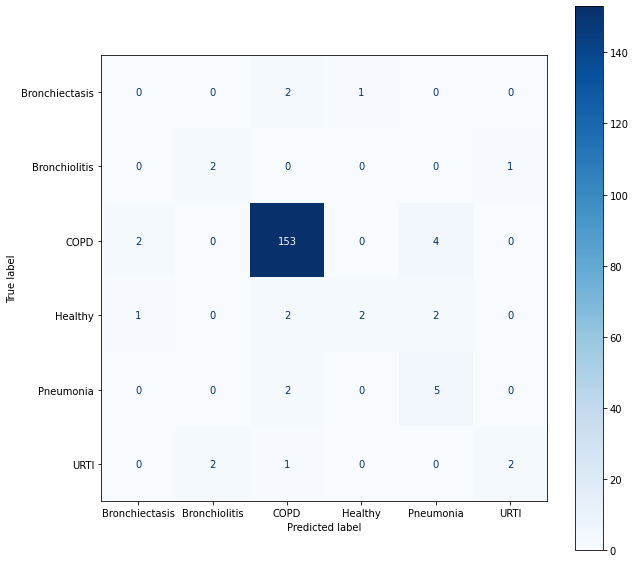

In [48]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=6)
pred_classesX = to_categorical(pred_classes, num_classes=6)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### densenet121

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.095238097012043.


Better model found at epoch 0 with accuracy value: 0.2448979616165161.
Better model found at epoch 1 with accuracy value: 0.41496598720550537.
Better model found at epoch 3 with accuracy value: 0.4897959232330322.
Better model found at epoch 4 with accuracy value: 0.6054421663284302.
Better model found at epoch 5 with accuracy value: 0.6190476417541504.
Better model found at epoch 6 with accuracy value: 0.6530612111091614.
Better model found at epoch 7 with accuracy value: 0.7074829936027527.
Better model found at epoch 8 with accuracy value: 0.7891156673431396.
Better model found at epoch 9 with accuracy value: 0.8707482814788818.
Better model found at epoch 11 with accuracy value: 0.8775510191917419.
Better model found at epoch 13 with accuracy value: 0.884353756904602.
Better model found at epoch 14 with accuracy value: 0.918367326259613.
Better model found at epoch 15 with accuracy value: 0.9319728016853333.
No improvement since epoch 15: early stopping


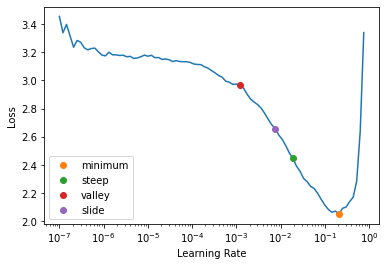

In [49]:
learn = cnn_learner(dls, densenet121, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fine_tune(50, lrs.valley)

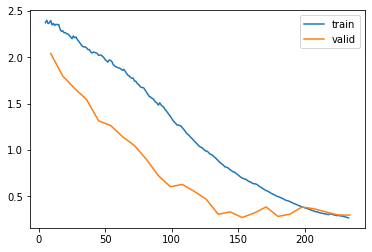

In [50]:
learn.recorder.plot_loss()

0.9184782608695652 0.8053321472608842 0.6426400098324389 0.6418388739143456 0.9688254206074226 0.7289783001808319
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.25      0.67      0.36         3
           2       0.98      0.97      0.98       159
           3       0.43      0.43      0.43         7
           4       0.71      0.71      0.71         7
           5       1.00      0.40      0.57         5

    accuracy                           0.92       184
   macro avg       0.73      0.64      0.64       184
weighted avg       0.94      0.92      0.92       184



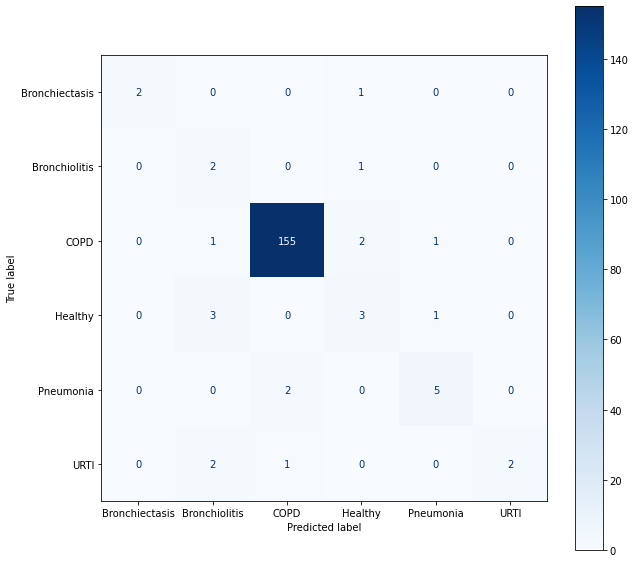

In [51]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=6)
pred_classesX = to_categorical(pred_classes, num_classes=6)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### xresnet50

Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to /root/.cache/torch/hub/checkpoints/xrn50_940.pth


  0%|          | 0.00/244M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.020408162847161293.


Better model found at epoch 0 with accuracy value: 0.1428571492433548.
Better model found at epoch 1 with accuracy value: 0.4761904776096344.
Better model found at epoch 2 with accuracy value: 0.6530612111091614.
Better model found at epoch 3 with accuracy value: 0.680272102355957.
Better model found at epoch 4 with accuracy value: 0.7551020383834839.
Better model found at epoch 5 with accuracy value: 0.7891156673431396.
Better model found at epoch 7 with accuracy value: 0.8503401279449463.
Better model found at epoch 8 with accuracy value: 0.8707482814788818.
Better model found at epoch 10 with accuracy value: 0.8775510191917419.
Better model found at epoch 12 with accuracy value: 0.884353756904602.
Better model found at epoch 13 with accuracy value: 0.8979591727256775.
Better model found at epoch 18 with accuracy value: 0.9115646481513977.
Better model found at epoch 20 with accuracy value: 0.918367326259613.
Better model found at epoch 27 with accuracy value: 0.9319728016853333.
No 

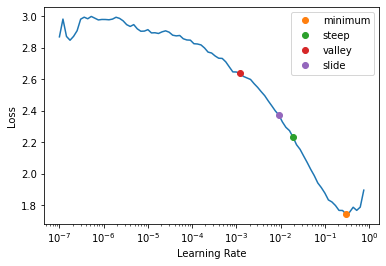

In [52]:
learn = cnn_learner(dls, xresnet50, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fine_tune(50, lrs.valley)

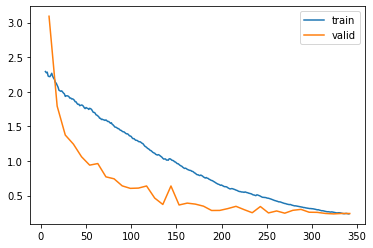

In [53]:
learn.recorder.plot_loss()

0.8967391304347826 0.8525951027333624 0.6232056117492427 0.72869122491764 0.9764989805490846 0.562005187005187
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       0.33      0.33      0.33         3
           2       0.99      0.92      0.96       159
           3       0.55      0.86      0.67         7
           4       0.50      0.86      0.63         7
           5       0.40      0.40      0.40         5

    accuracy                           0.90       184
   macro avg       0.56      0.73      0.62       184
weighted avg       0.92      0.90      0.91       184



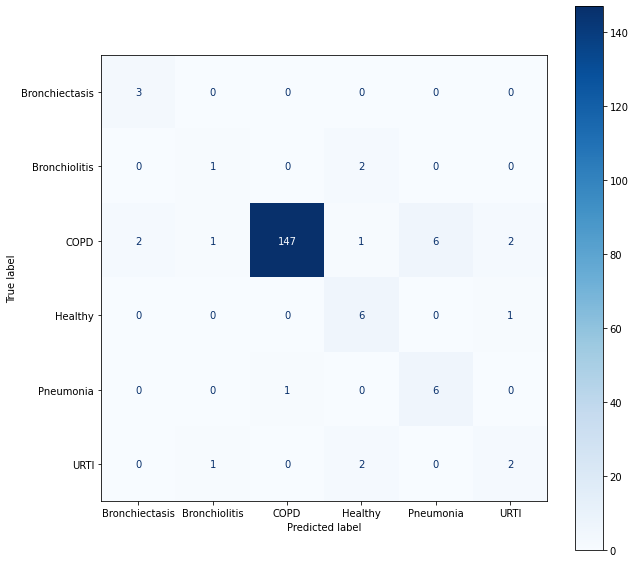

In [54]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=6)
pred_classesX = to_categorical(pred_classes, num_classes=6)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

# Models: 1cycle policy

### ResNet-18

Better model found at epoch 0 with accuracy value: 0.08843537420034409.
Better model found at epoch 1 with accuracy value: 0.12925170361995697.
Better model found at epoch 2 with accuracy value: 0.3741496503353119.
Better model found at epoch 3 with accuracy value: 0.6054421663284302.
Better model found at epoch 4 with accuracy value: 0.680272102355957.
Better model found at epoch 5 with accuracy value: 0.7278911471366882.
Better model found at epoch 6 with accuracy value: 0.8027210831642151.
Better model found at epoch 7 with accuracy value: 0.8435373902320862.
Better model found at epoch 8 with accuracy value: 0.8571428656578064.
Better model found at epoch 9 with accuracy value: 0.8707482814788818.
Better model found at epoch 10 with accuracy value: 0.918367326259613.
Better model found at epoch 13 with accuracy value: 0.9251700639724731.
Better model found at epoch 20 with accuracy value: 0.9455782175064087.
Better model found at epoch 28 with accuracy value: 0.9523809552192688.
Be

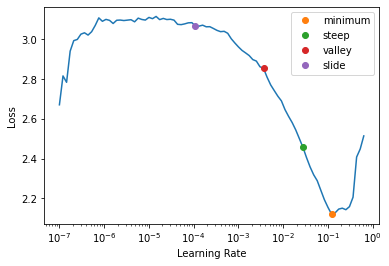

In [55]:
learn = cnn_learner(dls, resnet18, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fit_one_cycle(50, lrs.valley)

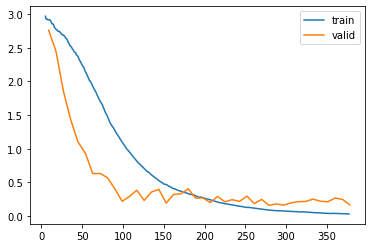

In [56]:
learn.recorder.plot_loss()

0.9293478260869565 0.8651895434611837 0.7260955958408187 0.7540281521413598 0.9763509347810077 0.8311827956989247
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       1.00      1.00      1.00         3
           2       0.99      0.96      0.97       159
           3       1.00      0.43      0.60         7
           4       0.50      1.00      0.67         7
           5       0.50      0.80      0.62         5

    accuracy                           0.93       184
   macro avg       0.83      0.75      0.73       184
weighted avg       0.96      0.93      0.93       184



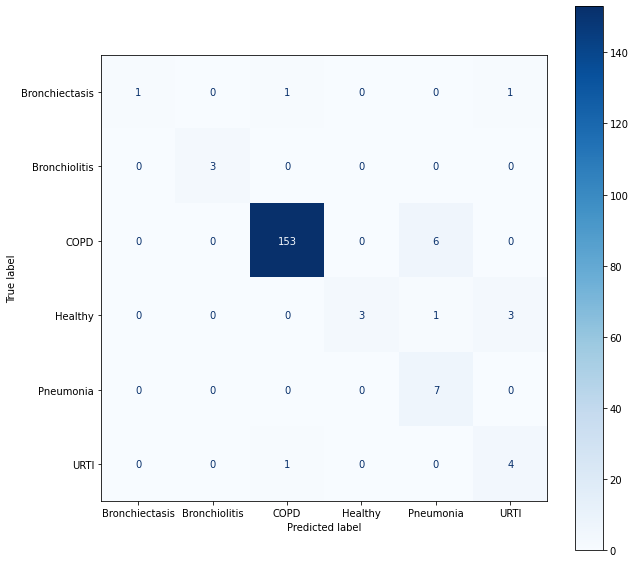

In [57]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=6)
pred_classesX = to_categorical(pred_classes, num_classes=6)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### ResNet-34

Better model found at epoch 0 with accuracy value: 0.17006802558898926.
Better model found at epoch 1 with accuracy value: 0.22448979318141937.
Better model found at epoch 2 with accuracy value: 0.29931971430778503.
Better model found at epoch 3 with accuracy value: 0.35374149680137634.
Better model found at epoch 4 with accuracy value: 0.4625850319862366.
Better model found at epoch 5 with accuracy value: 0.5714285969734192.
Better model found at epoch 6 with accuracy value: 0.5850340127944946.
Better model found at epoch 7 with accuracy value: 0.7482993006706238.
Better model found at epoch 8 with accuracy value: 0.7687074542045593.
Better model found at epoch 9 with accuracy value: 0.7823129296302795.
Better model found at epoch 10 with accuracy value: 0.8639456033706665.
Better model found at epoch 11 with accuracy value: 0.884353756904602.
Better model found at epoch 13 with accuracy value: 0.8911564350128174.
Better model found at epoch 14 with accuracy value: 0.9115646481513977.

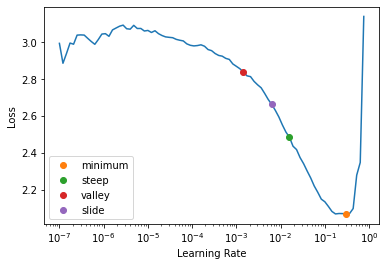

In [58]:
learn = cnn_learner(dls, resnet34, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fit_one_cycle(50, lrs.valley)

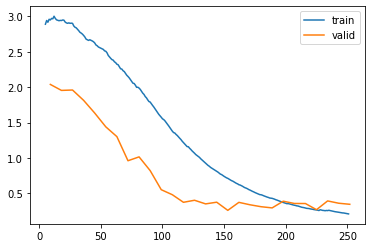

In [59]:
learn.recorder.plot_loss()

0.8858695652173914 0.6950413728058228 0.3521100246339863 0.42123390236597785 0.9688488432456676 0.315007215007215
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         3
           2       0.99      0.96      0.97       159
           3       0.27      0.57      0.36         7
           4       0.64      1.00      0.78         7
           5       0.00      0.00      0.00         5

    accuracy                           0.89       184
   macro avg       0.32      0.42      0.35       184
weighted avg       0.89      0.89      0.88       184



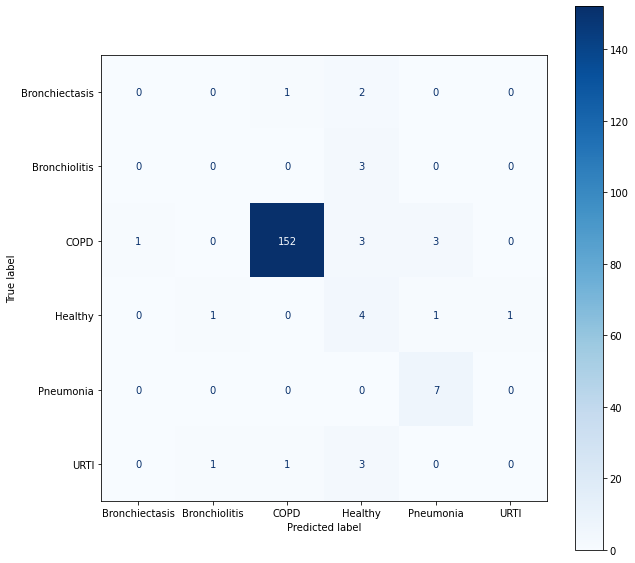

In [60]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=6)
pred_classesX = to_categorical(pred_classes, num_classes=6)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### ResNet-50

Better model found at epoch 0 with accuracy value: 0.0476190485060215.
Better model found at epoch 1 with accuracy value: 0.1428571492433548.
Better model found at epoch 2 with accuracy value: 0.21088434755802155.
Better model found at epoch 3 with accuracy value: 0.3877550959587097.
Better model found at epoch 4 with accuracy value: 0.557823121547699.
Better model found at epoch 5 with accuracy value: 0.6258503198623657.
Better model found at epoch 6 with accuracy value: 0.7891156673431396.
Better model found at epoch 7 with accuracy value: 0.8639456033706665.
Better model found at epoch 8 with accuracy value: 0.8707482814788818.
Better model found at epoch 9 with accuracy value: 0.918367326259613.
Better model found at epoch 10 with accuracy value: 0.9319728016853333.
Better model found at epoch 19 with accuracy value: 0.9523809552192688.
No improvement since epoch 19: early stopping


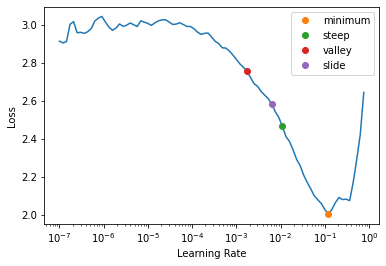

In [61]:
learn = cnn_learner(dls, resnet50, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fit_one_cycle(50, lrs.valley)

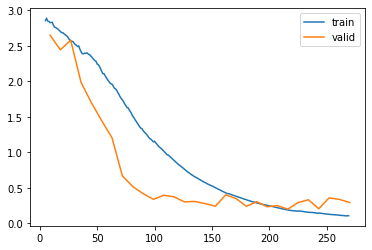

In [62]:
learn.recorder.plot_loss()

0.9021739130434783 0.861229882418355 0.651613036682432 0.7392632524707996 0.9831965123659102 0.648313492063492
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       0.29      0.67      0.40         3
           2       1.00      0.93      0.96       159
           3       0.67      0.57      0.62         7
           4       0.44      1.00      0.61         7
           5       1.00      0.60      0.75         5

    accuracy                           0.90       184
   macro avg       0.65      0.74      0.65       184
weighted avg       0.95      0.90      0.92       184



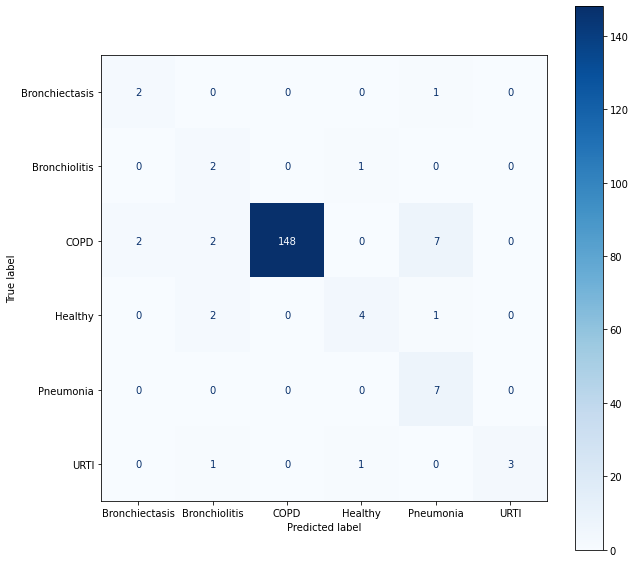

In [63]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=6)
pred_classesX = to_categorical(pred_classes, num_classes=6)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### ResNet-101

Better model found at epoch 0 with accuracy value: 0.06802721321582794.
Better model found at epoch 1 with accuracy value: 0.07482992857694626.
Better model found at epoch 2 with accuracy value: 0.2857142984867096.
Better model found at epoch 3 with accuracy value: 0.5034013390541077.
Better model found at epoch 4 with accuracy value: 0.7278911471366882.
Better model found at epoch 6 with accuracy value: 0.8163265585899353.
Better model found at epoch 7 with accuracy value: 0.8707482814788818.
Better model found at epoch 8 with accuracy value: 0.9047619104385376.
Better model found at epoch 11 with accuracy value: 0.9319728016853333.
Better model found at epoch 13 with accuracy value: 0.9387755393981934.
No improvement since epoch 13: early stopping


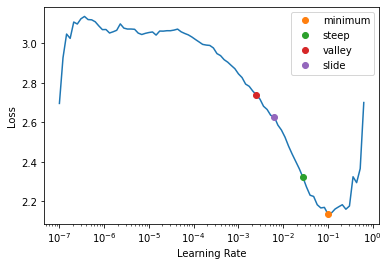

In [64]:
learn = cnn_learner(dls, resnet101, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fit_one_cycle(50, lrs.valley)

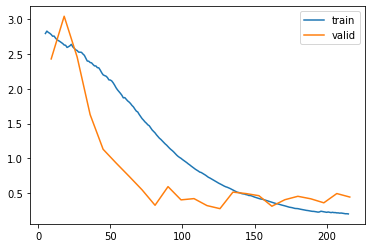

In [65]:
learn.recorder.plot_loss()

0.907608695652174 0.7577400846831609 0.5665411882803187 0.5714585205151242 0.9440216488511973 0.6761758691206543
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.50      1.00      0.67         3
           2       0.96      0.98      0.97       159
           3       0.60      0.43      0.50         7
           4       0.67      0.29      0.40         7
           5       0.33      0.40      0.36         5

    accuracy                           0.91       184
   macro avg       0.68      0.57      0.57       184
weighted avg       0.91      0.91      0.90       184



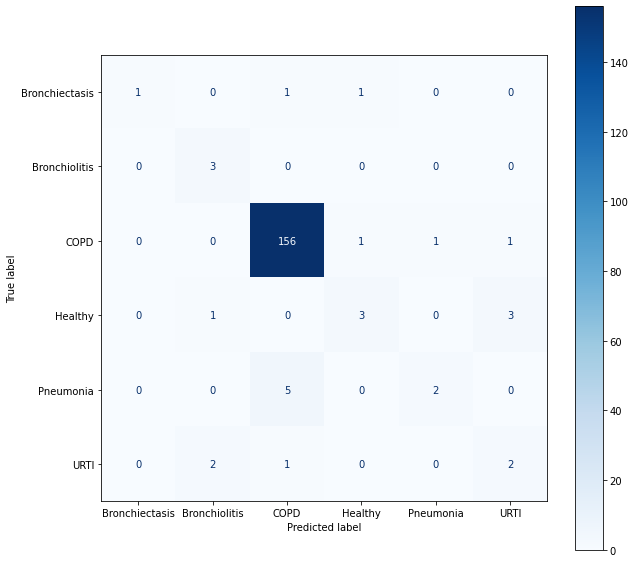

In [66]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=6)
pred_classesX = to_categorical(pred_classes, num_classes=6)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### vgg16_bn

Better model found at epoch 0 with accuracy value: 0.0476190485060215.
Better model found at epoch 1 with accuracy value: 0.054421767592430115.
Better model found at epoch 2 with accuracy value: 0.1972789168357849.
Better model found at epoch 3 with accuracy value: 0.380952388048172.
Better model found at epoch 4 with accuracy value: 0.5170068144798279.
Better model found at epoch 5 with accuracy value: 0.6054421663284302.
Better model found at epoch 6 with accuracy value: 0.6870748400688171.
Better model found at epoch 7 with accuracy value: 0.795918345451355.
Better model found at epoch 9 with accuracy value: 0.8367347121238708.
Better model found at epoch 10 with accuracy value: 0.8571428656578064.
Better model found at epoch 11 with accuracy value: 0.8707482814788818.
Better model found at epoch 13 with accuracy value: 0.8979591727256775.
Better model found at epoch 14 with accuracy value: 0.918367326259613.
Better model found at epoch 16 with accuracy value: 0.9251700639724731.
Be

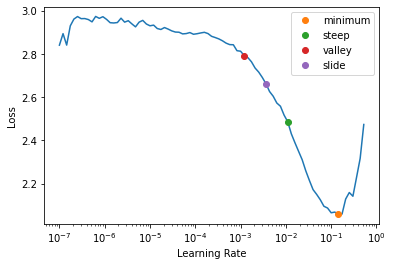

In [67]:
learn = cnn_learner(dls, vgg16_bn, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fit_one_cycle(50, lrs.valley)

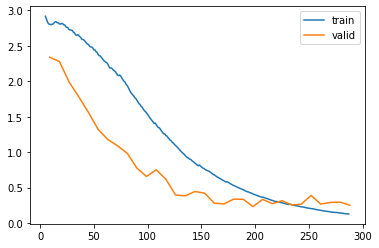

In [68]:
learn.recorder.plot_loss()

0.907608695652174 0.8580984959313356 0.6841982091982092 0.7492961964660076 0.9669007953966634 0.6455054749172396
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.60      1.00      0.75         3
           2       0.98      0.94      0.96       159
           3       0.57      0.57      0.57         7
           4       0.45      0.71      0.56         7
           5       0.60      0.60      0.60         5

    accuracy                           0.91       184
   macro avg       0.65      0.75      0.68       184
weighted avg       0.92      0.91      0.91       184



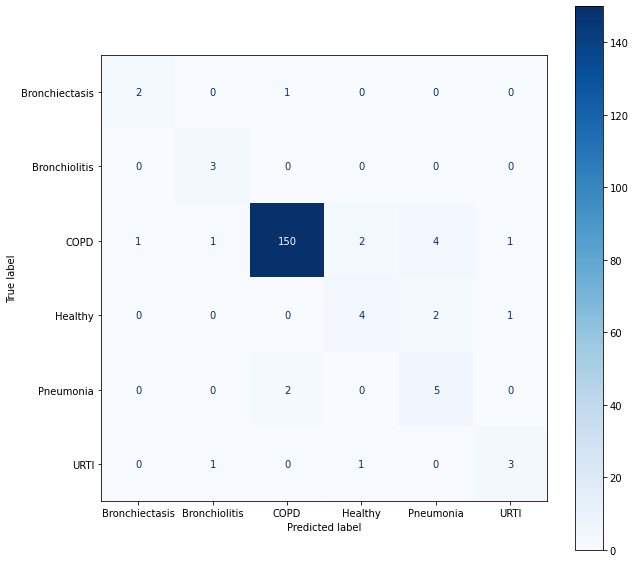

In [69]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=6)
pred_classesX = to_categorical(pred_classes, num_classes=6)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### vgg19_bn

Better model found at epoch 0 with accuracy value: 0.095238097012043.
Better model found at epoch 1 with accuracy value: 0.12244898080825806.
Better model found at epoch 2 with accuracy value: 0.26530611515045166.
Better model found at epoch 3 with accuracy value: 0.40816327929496765.
Better model found at epoch 4 with accuracy value: 0.49659863114356995.
Better model found at epoch 5 with accuracy value: 0.5646258592605591.
Better model found at epoch 6 with accuracy value: 0.6394557952880859.
Better model found at epoch 7 with accuracy value: 0.7823129296302795.
Better model found at epoch 8 with accuracy value: 0.795918345451355.
Better model found at epoch 9 with accuracy value: 0.8435373902320862.
Better model found at epoch 10 with accuracy value: 0.9047619104385376.
Better model found at epoch 11 with accuracy value: 0.9251700639724731.
No improvement since epoch 11: early stopping


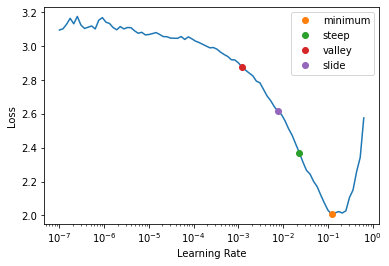

In [70]:
learn = cnn_learner(dls, vgg19_bn, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fit_one_cycle(50, lrs.valley)

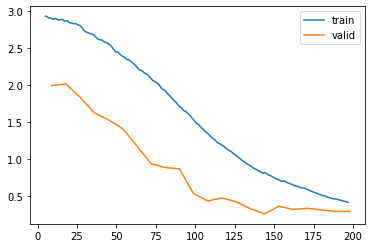

In [71]:
learn.recorder.plot_loss()

0.842391304347826 0.7651389434817376 0.4628175479168857 0.5631326744534292 0.9671452125100464 0.42206404706404704
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       0.29      0.67      0.40         3
           2       0.99      0.89      0.94       159
           3       0.29      0.57      0.38         7
           4       0.38      0.71      0.50         7
           5       0.25      0.20      0.22         5

    accuracy                           0.84       184
   macro avg       0.42      0.56      0.46       184
weighted avg       0.90      0.84      0.86       184



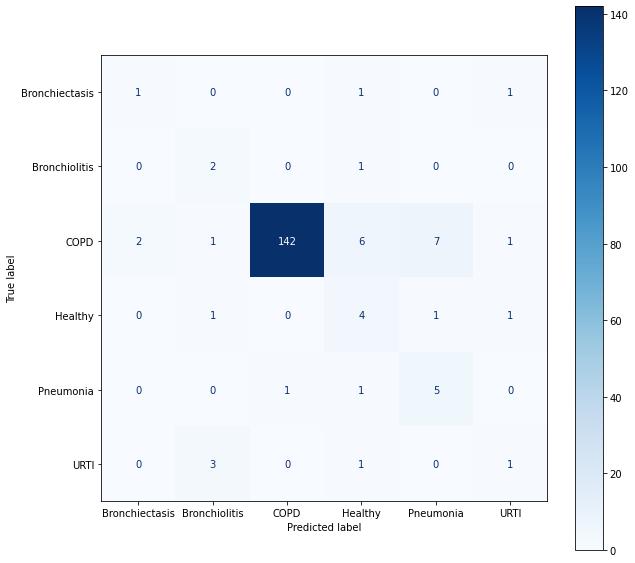

In [72]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=6)
pred_classesX = to_categorical(pred_classes, num_classes=6)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### alexnet

Better model found at epoch 0 with accuracy value: 0.14965985715389252.
Better model found at epoch 1 with accuracy value: 0.3469387888908386.
Better model found at epoch 2 with accuracy value: 0.4897959232330322.
Better model found at epoch 3 with accuracy value: 0.5850340127944946.
Better model found at epoch 4 with accuracy value: 0.7074829936027527.
Better model found at epoch 5 with accuracy value: 0.7346938848495483.
Better model found at epoch 6 with accuracy value: 0.7891156673431396.
Better model found at epoch 7 with accuracy value: 0.8231292366981506.
Better model found at epoch 8 with accuracy value: 0.8707482814788818.
Better model found at epoch 9 with accuracy value: 0.884353756904602.
Better model found at epoch 11 with accuracy value: 0.8979591727256775.
Better model found at epoch 16 with accuracy value: 0.9115646481513977.
Better model found at epoch 22 with accuracy value: 0.9319728016853333.
No improvement since epoch 22: early stopping


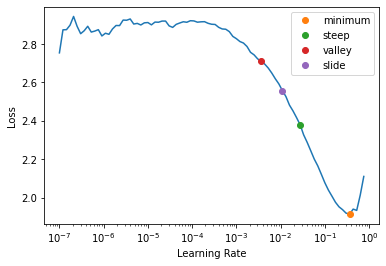

In [73]:
learn = cnn_learner(dls, alexnet, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fit_one_cycle(50, lrs.valley)

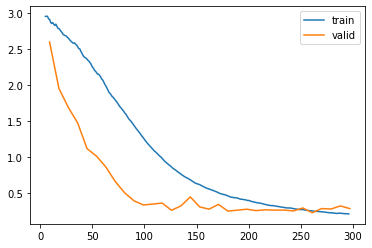

In [74]:
learn.recorder.plot_loss()

0.8695652173913043 0.6170514264714309 0.34146641112585385 0.3138065289008685 0.9202963240419931 0.4612659698025552
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         3
           2       0.94      0.97      0.95       159
           3       0.43      0.43      0.43         7
           4       0.40      0.29      0.33         7
           5       1.00      0.20      0.33         5

    accuracy                           0.87       184
   macro avg       0.46      0.31      0.34       184
weighted avg       0.87      0.87      0.86       184



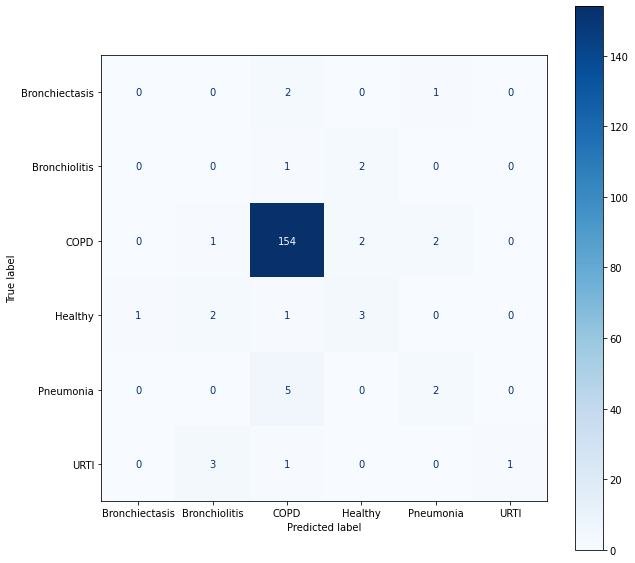

In [75]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=6)
pred_classesX = to_categorical(pred_classes, num_classes=6)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### squeezenet1_0

Better model found at epoch 0 with accuracy value: 0.18367347121238708.
Better model found at epoch 1 with accuracy value: 0.25850340723991394.
Better model found at epoch 2 with accuracy value: 0.36734694242477417.
Better model found at epoch 3 with accuracy value: 0.45578232407569885.
Better model found at epoch 4 with accuracy value: 0.5374149680137634.
Better model found at epoch 5 with accuracy value: 0.6666666865348816.
Better model found at epoch 6 with accuracy value: 0.7346938848495483.
Better model found at epoch 7 with accuracy value: 0.761904776096344.
Better model found at epoch 8 with accuracy value: 0.8163265585899353.
Better model found at epoch 9 with accuracy value: 0.8435373902320862.
Better model found at epoch 10 with accuracy value: 0.8775510191917419.
Better model found at epoch 14 with accuracy value: 0.8911564350128174.
Better model found at epoch 16 with accuracy value: 0.9115646481513977.
Better model found at epoch 25 with accuracy value: 0.918367326259613.


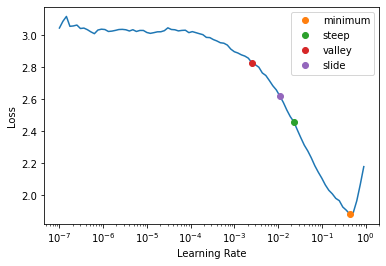

In [76]:
learn = cnn_learner(dls, squeezenet1_0, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fit_one_cycle(50, lrs.valley)

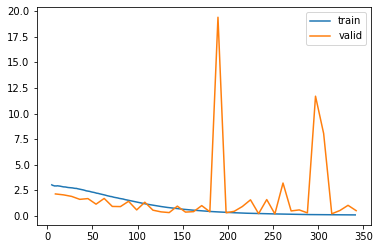

In [77]:
learn.recorder.plot_loss()

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: 

0.907608695652174 0.7449782086040787 0.5233630952380952 0.5402515723270439 0.9497048448811136 0.5104554865424431
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.50      0.67      0.57         3
           2       0.96      0.97      0.97       159
           3       0.43      0.43      0.43         7
           4       0.57      0.57      0.57         7
           5       0.60      0.60      0.60         5

    accuracy                           0.91       184
   macro avg       0.51      0.54      0.52       184
weighted avg       0.89      0.91      0.90       184



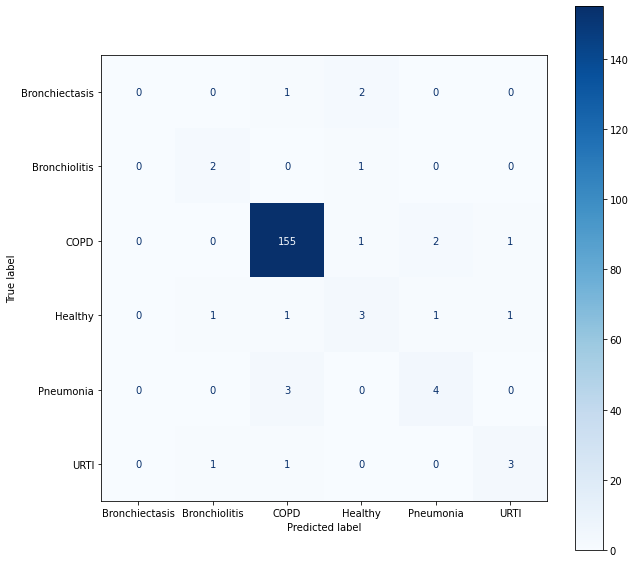

In [78]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=6)
pred_classesX = to_categorical(pred_classes, num_classes=6)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### densenet121

Better model found at epoch 0 with accuracy value: 0.30612245202064514.
Better model found at epoch 2 with accuracy value: 0.3401360511779785.
Better model found at epoch 3 with accuracy value: 0.5510203838348389.
Better model found at epoch 4 with accuracy value: 0.6870748400688171.
Better model found at epoch 5 with accuracy value: 0.7414966225624084.
Better model found at epoch 6 with accuracy value: 0.7755101919174194.
Better model found at epoch 7 with accuracy value: 0.8571428656578064.
Better model found at epoch 8 with accuracy value: 0.918367326259613.
Better model found at epoch 12 with accuracy value: 0.9455782175064087.
No improvement since epoch 12: early stopping


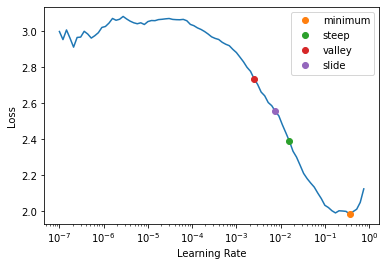

In [79]:
learn = cnn_learner(dls, densenet121, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fit_one_cycle(50, lrs.valley)

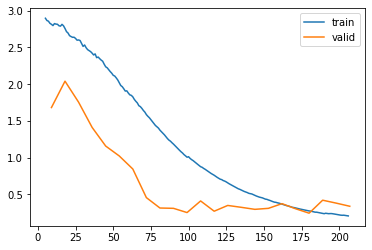

In [80]:
learn.recorder.plot_loss()

0.9347826086956522 0.7971799553609439 0.638320707070707 0.6227613057801737 0.9715986049417139 0.6774499654934437
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.33      0.33      0.33         3
           2       0.98      0.99      0.99       159
           3       0.50      0.29      0.36         7
           4       0.75      0.86      0.80         7
           5       0.50      0.60      0.55         5

    accuracy                           0.93       184
   macro avg       0.68      0.62      0.64       184
weighted avg       0.93      0.93      0.93       184



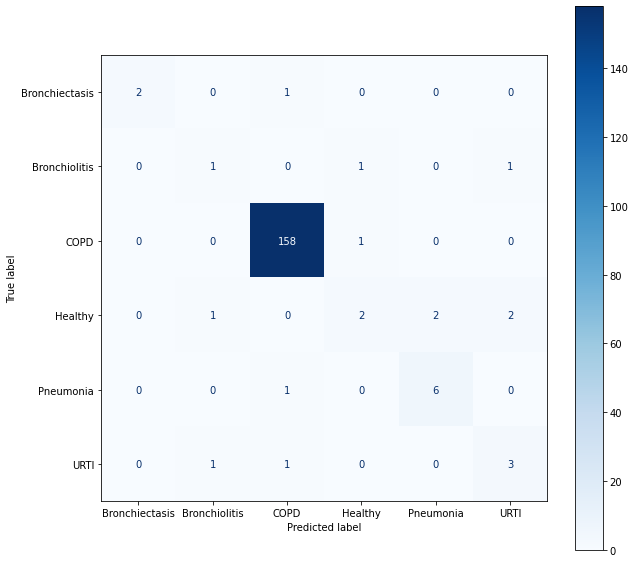

In [81]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=6)
pred_classesX = to_categorical(pred_classes, num_classes=6)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### xresnet50

Better model found at epoch 0 with accuracy value: 0.020408162847161293.
Better model found at epoch 1 with accuracy value: 0.08843537420034409.
Better model found at epoch 2 with accuracy value: 0.31292515993118286.
Better model found at epoch 3 with accuracy value: 0.646258533000946.
Better model found at epoch 4 with accuracy value: 0.7074829936027527.
Better model found at epoch 5 with accuracy value: 0.795918345451355.
Better model found at epoch 6 with accuracy value: 0.8503401279449463.
Better model found at epoch 7 with accuracy value: 0.8775510191917419.
Better model found at epoch 8 with accuracy value: 0.884353756904602.
Better model found at epoch 9 with accuracy value: 0.8911564350128174.
Better model found at epoch 10 with accuracy value: 0.918367326259613.
Better model found at epoch 11 with accuracy value: 0.9251700639724731.
Better model found at epoch 13 with accuracy value: 0.9319728016853333.
Better model found at epoch 23 with accuracy value: 0.9455782175064087.
No

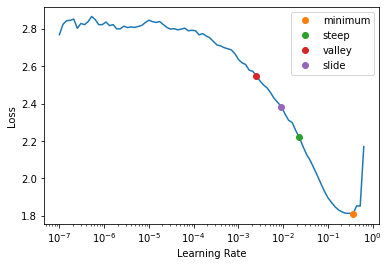

In [82]:
learn = cnn_learner(dls, xresnet50, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fit_one_cycle(50, lrs.valley)

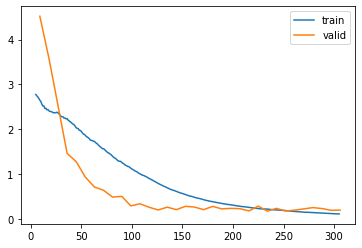

In [83]:
learn.recorder.plot_loss()

0.9293478260869565 0.8763266080365999 0.7201828811045745 0.7762503743635817 0.9764028417096178 0.689516129032258
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.50      0.67      0.57         3
           2       0.99      0.96      0.97       159
           3       0.80      0.57      0.67         7
           4       0.60      0.86      0.71         7
           5       0.50      0.60      0.55         5

    accuracy                           0.93       184
   macro avg       0.69      0.78      0.72       184
weighted avg       0.94      0.93      0.93       184



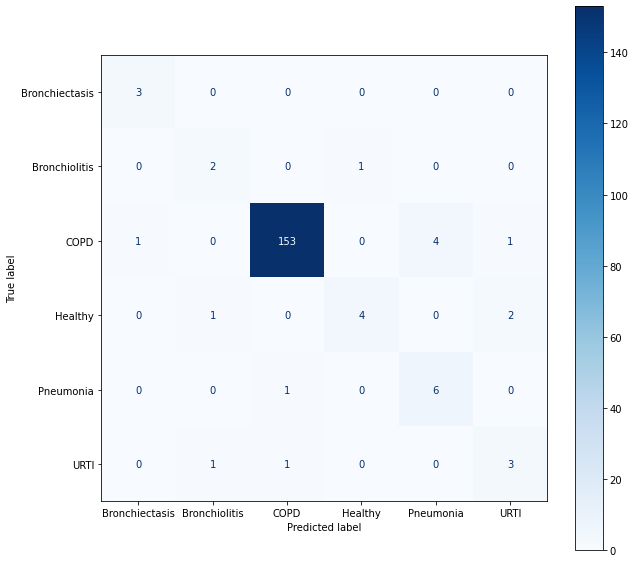

In [84]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=6)
pred_classesX = to_categorical(pred_classes, num_classes=6)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()